서론 : 본 과제는 신용카드 거래 데이터(fraud.csv)를 바탕으로 사기 거래 여부 예측을 위한 전처리 및 특징 생성 작업을 수행하는 것을 목표로한다. 이를 위해 전처리가 필요한 컬럼을 선정하고, 개인정보는 가림 처리하며, 결측치·이상치·클래스 불균형·데이터 일관성 문제를 순차적으로 해결했다. 또한 거래 시각·연령·거리 기반 파생 변수를 생성하여 사기 거래의 시간대 및 행동 패턴을 확인하여 추가적인 분석의 기반을 마련하고자 한다.

In [7]:
# =========================================
# 구글 드라이브 마운트 & 라이브러리 불러오기
# =========================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# =========================================
# CSV 파일 불러오기
#    - fraud.csv 위치: MyDrive/데이터분석/fraud.csv
# =========================================
file_path = "/content/drive/MyDrive/데이터분석/fraud.csv"

fraud_df = pd.read_csv(file_path)
fraud_df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,...,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,...,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,...,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,...,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0


In [9]:
# =========================================
# 예측에 기여하지 않는 불필요한 컬럼(개인정보) 삭제
# - 카드번호, 이름, 주소, 직업, 거래 ID 등
# - 사기 여부 예측에 직접적인 도움 X + 개인정보라 삭제
# =========================================
drop_cols = [
    "cc_num", "first", "last", "street", "city",
    "state", "zip", "job", "trans_num"
]  # 예측에 기여하지 않는 불필요한 컬럼 (개인정보) 삭제

fraud_df = fraud_df.drop(columns=drop_cols)
fraud_df.head()


,trans_date_trans_time,merchant,category,amt,gender,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,fraud_Kling-Grant,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,fraud_Deckow-O'Conner,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,fraud_Balistreri-Nader,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,1325377421,29.737426,-90.853194,0


In [11]:
# =========================================
# 데이터 일관성 처리 (날짜 → datetime 형식 변환)
# - 거래 시간, 나이 등 파생변수 생성을 위해 변환
# =========================================
fraud_df["trans_datetime"] = pd.to_datetime(fraud_df["trans_date_trans_time"])
fraud_df["dob_datetime"] = pd.to_datetime(fraud_df["dob"], errors="coerce")


In [12]:
# =========================================
# 파생 변수 생성
#  1) trans_hour: 거래가 일어난 시 (0~23시)
#  2) age: 거래 시점 기준 고객 나이
#  3) cust_merch_distance: 고객 위치 ~ 가맹점 위치 간 거리
# =========================================

# 4-1) 거래 시간(시)
fraud_df["trans_hour"] = fraud_df["trans_datetime"].dt.hour

# 4-2) 고객 나이
fraud_df["age"] = (
    (fraud_df["trans_datetime"] - fraud_df["dob_datetime"]).dt.days / 365.25
).round(1)

# 4-3) 고객 ↔ 가맹점 거리 (대략적인 거리)
fraud_df["cust_merch_distance"] = np.sqrt(
    (fraud_df["lat"] - fraud_df["merch_lat"])**2 +
    (fraud_df["long"] - fraud_df["merch_long"])**2
)

fraud_df[["trans_hour", "age", "cust_merch_distance"]].head()


,trans_hour,age,cust_merch_distance
0,0,40.5,0.272310
1,0,38.0,0.862420
2,0,44.5,0.622027
3,0,47.2,0.239327
4,0,41.9,0.730752


In [13]:
# =========================================
# 결측치 처리
# - 분석/모델에 중요하다고 보는 변수들 기준으로 결측 행 제거
# - (amt, trans_hour, age, cust_merch_distance, is_fraud)
# =========================================
key_cols = ["amt", "trans_hour", "age", "cust_merch_distance", "is_fraud"]

fraud_df = fraud_df.dropna(subset=key_cols)

fraud_df[key_cols].isna().sum()


,0
amt,0
trans_hour,0
age,0
cust_merch_distance,0
is_fraud,0


In [14]:
# =========================================
# 이상치 처리
# - 금액이 0 이하인 거래는 비정상 → 제거
# =========================================
fraud_df = fraud_df[fraud_df["amt"] > 0]

fraud_df["amt"].describe()
#분석사항:거래 금액의 중앙값은 42달러로 대부분 소액 거래지만, 최대 25,000달러 수준의 고액 거래가 존재하여 분산이 크고 우측으로 치우친 분포를 보인다.


,amt
count,491134.000000
mean,69.050120
std,160.322867
min,1.000000
25%,8.960000
50%,42.170000
75%,80.330000
max,25086.940000


In [15]:
# =========================================
# 클래스 불균형 확인
# - 사기 거래 비율이 얼마나 적은지 확인 (불균형 정도 파악)
# =========================================
fraud_df["is_fraud"].value_counts(normalize=True)
#분석사항 :전체 거래 중 0.2533%만 사기 거래임을 확인

,proportion
is_fraud,
0,0.997467
1,0.002533


In [16]:
# =========================================
# 시간대별 사기 거래 패턴 확인
# - trans_hour별 사기 비율(mean) 계산
# =========================================
hour_fraud_rate = fraud_df.groupby("trans_hour")["is_fraud"].mean()
hour_fraud_rate
#분석사ㅏㅇ : 사기 거래는 심야 시간(0~3시)와 늦은 밤(22~23시)에 집중되며, 낮 시간대에는 거의 발생하지 않는것을 확인할 수 있음


,is_fraud
trans_hour,
0,0.011446
1,0.010837
2,0.012185
3,0.013010
4,0.001232
5,0.001479
6,0.000702
7,0.001727
8,0.001214


<Axes: title={'center': '시간대별 사기 거래 비율'}, xlabel='trans_hour'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) mis

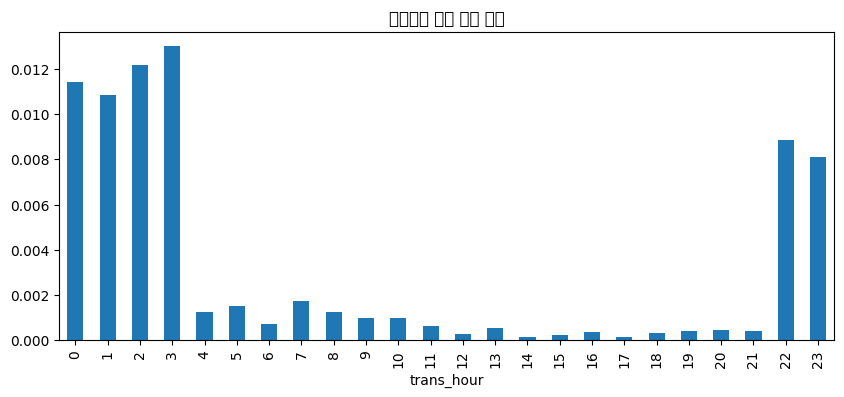

In [17]:
#바 차트로 시각화해서 보기
hour_fraud_rate.plot(kind="bar", figsize=(10, 4), title="시간대별 사기 거래 비율")


In [18]:
# =========================================
# 최종 데이터 구조 확인
# =========================================
fraud_df.info()
fraud_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  491134 non-null  object        
 1   merchant               491134 non-null  object        
 2   category               491134 non-null  object        
 3   amt                    491134 non-null  float64       
 4   gender                 491134 non-null  object        
 5   lat                    491134 non-null  float64       
 6   long                   491134 non-null  float64       
 7   city_pop               491134 non-null  int64         
 8   dob                    491134 non-null  object        
 9   unix_time              491134 non-null  int64         
 10  merch_lat              491134 non-null  float64       
 11  merch_long             491134 non-null  float64       
 12  is_fraud               491134 non-null  int6

,trans_date_trans_time,merchant,category,amt,gender,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud,trans_datetime,dob_datetime,trans_hour,age,cust_merch_distance
0,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,1978-06-21,0,40.5,0.272310
1,2019-01-01 00:12:34,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,1325376754,40.079588,-74.848087,0,2019-01-01 00:12:34,1980-12-21,0,38.0,0.862420
2,2019-01-01 00:17:16,fraud_Kling-Grant,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,1325377036,40.021888,-74.228188,0,2019-01-01 00:17:16,1974-07-19,0,44.5,0.622027
3,2019-01-01 00:20:15,fraud_Deckow-O'Conner,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,1325377215,42.360426,-83.552316,0,2019-01-01 00:20:15,1971-11-05,0,47.2,0.239327
4,2019-01-01 00:23:41,fraud_Balistreri-Nader,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,1325377421,29.737426,-90.853194,0,2019-01-01 00:23:41,1977-02-22,0,41.9,0.730752


**전처리 과정 요약**
본 프로젝트에서는 사기 거래 여부 예측을 위한 데이터 전처리를 수행하였다. 먼저 카드번호, 이름, 주소, 직업 등 개인정보이자 예측에 기여하지 않는 변수를 제거함으로써 데이터 누수 위험을 제거하였다. 이후 거래 일시와 생년월일을 datetime 형식으로 변환하고, 거래 시각(trans_hour), 고객 나이(age), 고객과 가맹점 간 거리(cust_merch_distance) 등 행동 기반 파생 변수를 생성하였다. 또한 핵심 변수 기준으로 결측치를 제거하고, 거래 금액이 0 이하인 이상치를 배제하여 분석 가능한 데이터 구조를 확보하였다. 클래스 불균형 확인 결과, 전체의 약 0.25%만 사기 거래로 나타나 극심한 불균형 문제를 확인하였다.

**시간대별 사기 패턴 분석 결과**
거래 시각별 사기 비율을 분석한 결과, 사기 거래는 심야 시간대(00~03시)와 늦은 밤(22~23시) 구간에서 현저히 높은 비율로 발생하였다. 낮 시간대(07~18시)에는 사기 비율이 거의 0에 가까웠다. 이는 실제 금융 사기 패턴이 피해자 및 카드사 대응이 느려지는 시간대임을 감안해 볼 수 있다.

결론 : 본 전처리 과정과 탐색적 분석을 통해 사기 거래는 특정 시간대·특정 행동 조건에서 비정상적으로 증가한다는 유의미한 탐지 단서를 확보하였다. 이는 향후 머신러닝 기반 탐지 모델의 성능을 개선할 수 있는 실질적인 인사이트이며, 추가적으로 거래 **금액·거리·고객 연령** 등의 속성과 **사기 여부의 상관관계**를 결합한다면, **시간 + 행동 기반 사기 유형을 보다 구체적으로 규명**할 수 있을 것으로 기대된다.